In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
%matplotlib inline
import os
import geopandas as gpd
from mpl_toolkits.mplot3d import Axes3D
from geopy.geocoders import Nominatim
import folium

In [2]:
address = 'Grote Markt 9, 3000 Leuven'# 'Andreas Vesaliusstraat 13 3000 Leuven '
df = gpd.tools.geocode(address)
df

,geometry,address
0,POINT (4.70174 50.87885),"Grote Markt, 3000, Leuven, Vlaams-Brabant, Bel..."


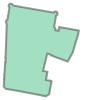

In [3]:
from shapely.geometry import Point, LineString, Polygon
from bs4 import BeautifulSoup
import requests 
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    points = info['polygon'][0]['coordinates'][0] 
    return points #info['polygon'][0]['coordinates'][0] 

pointList = get_coordinates(address)
pointList
poly = Polygon([[p[0], p[1]] for p in pointList])

# print(poly.wkt) 
# pointList
poly

In [4]:
import rioxarray as rxr
# geometry = poly
geometries = [{'type': 'Polygon','coordinates': [pointList]}]
clipped = rxr.open_rasterio("./Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif", masked=True)
clipped.rio.clip(geometries, from_disk = True)
# clipped.plot() 

<xarray.DataArray (band: 1, y: 70, x: 57)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 1.734e+05 1.734e+05 ... 1.734e+05 1.734e+05
  * y            (y) float64 1.743e+05 1.743e+05 ... 1.743e+05 1.743e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  223.13000488281
    STATISTICS_MEAN:     70.077058044048
    STATISTICS_MINIMUM:  11.270000457764
    STATISTICS_STDDEV:   22.480854668957
    scale_factor:        1.0
    add_offset:          0.0

In [5]:
# note how one time slice was selected on export to make the dataset 2D
# clipped.rio.to_raster("clipped_scope.tif")


In [6]:
# with rasterio.open("./Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif") as src:
#     out_image, out_transform = rasterio.mask.mask(src, [poly["geometry"]], crop=True)
#     out_meta = src.meta

#     out_meta.update(
#         {
#             "height": out_image.shape[1],
#             "width": out_image.shape[2],
#             "transform": out_transform,
#         }
#     )

#     with rasterio.open("output_raster.tif", "w", **out_meta) as dest:
#         dest.write(out_image)

In [7]:
import fiona
import pandas as pd
# define schema
schema = {
    'geometry':'Polygon',
    'properties':[('Name','str')]
}
#open a fiona object
polyShp = fiona.open('./Data/cropPoly.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:31370")

rowDict = {
'geometry' : {'type':'Polygon',
                 'coordinates': [pointList]}, #Here the xyList is in brackets
'properties': {'Name' : ''},
}
polyShp.write(rowDict)
#close fiona object
polyShp.close()

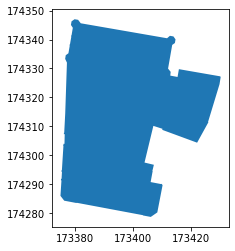

In [8]:
#Read Shape files
shape_df = gpd.read_file('Data/cropPoly.shp')
# x0 = shape_df.loc[1, 'geometry']
# x0
shape_df.crs
# print(shape_df.crs)
shape_df.head()

shape_df.plot()
plt.show()

In [9]:
# #intersecting
# Building = gpd.overlay(src, shape_df, how = 'intersection')

In [10]:
dsm = rxr.open_rasterio("./Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif", masked=True).squeeze()
crop_extent = gpd.read_file("./Data/cropPoly.shp")

#check CRS
print('dsm: ', dsm.rio.crs)
print('aoi: ', crop_extent.crs)



dsm:  EPSG:31370
aoi:  epsg:31370


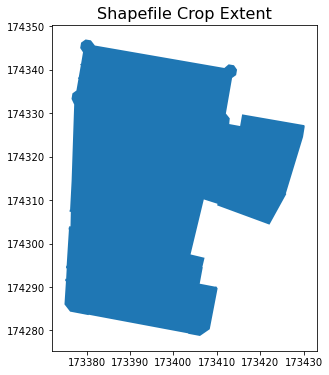

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

crop_extent.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

In [12]:
from shapely.geometry import mapping
# f, ax = plt.subplots(figsize=(10, 5))
# dsm.plot.imshow(ax=ax)

# crop_extent.plot(ax=ax,
#                  alpha=.8)
# ax.set(title="Raster Layer with Shapefile Overlayed")

# ax.set_axis_off()
# plt.show()

lidar_clipped = dsm.rio.clip(crop_extent.geometry.apply(mapping))#

# f, ax = plt.subplots(figsize=(10, 4))
# lidar_clipped.plot(ax=ax)
# ax.set(title="Raster Layer Cropped to Geodataframe Extent")
# ax.set_axis_off()
# plt.show()

In [13]:
lidar_clipped.rio.to_raster(f"./Data/{address}.tif")

In [14]:
# clipped_chm = rxr.open_rasterio(f"./Data/{address}.tif")
DSM_img = rasterio.open(f"./Data/{address}.tif", masked=True)
DSM_arr = DSM_img.read()
X,Y = DSM_arr[0].shape

X



# # Customize your plot as you wish!
# f, ax = plt.subplots(figsize=(10, 4))
# clipped_chm.plot(ax=ax,
#                  cmap='Greys')
# ax.set(title="Final Clipped CHM")
# ax.set_axis_off()
# plt.show()

68

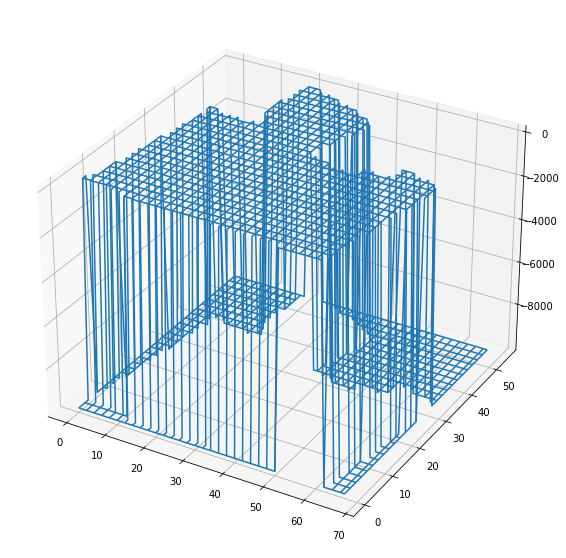

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate

x= range(X)
y = range (Y)
x,y = np.meshgrid(x, y, indexing='ij')

z = DSM_arr[0]

# xnew, ynew = np.mgrid[range(250), range(250)]
# tck = interpolate.bisplrep(x, y, z, s=0)
# znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

z.shape
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
# ax.plot_surface(x,y,z)
ax.plot_wireframe(x,y,z)
# plt.figure()
# plt.scatter(x, y, z)
plt.show()